___
# Loading the data and libraries
___

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

while any(marker in os.getcwd() for marker in ('workspace')):
    os.chdir("..")
sys.path.append('classes_and_functions')
os.getcwd()

'/Users/nicko/Documents/Lodz/Multivariate Data Analysis/Projects/team2'

In [2]:
# Base packages
from colorama import Fore, Back, Style
from typing import Optional, List

# Third-party packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

# Internal packages
from classes_and_functions.custom_transformers import (
    DropColumnTransformer,
    CustomImputer,
    CustomStandardScaler,
    CustomLabelEncoder,
    CustomOneHotEncoder,
    CustomOutlierDetector,
    CustomOutlierRemover,
    CustomMinMaxScaler,
)
from classes_and_functions.visualisation import classification_report_print
from classes_and_functions.visualisation import compute_and_plot_confusion_matrix

from classes_and_functions.classification import CustomClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import xgboost as xgb

In [3]:
raw_data = pd.read_csv('attachments//apple_quality.csv')
raw_data.head()

A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0   0.0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1   1.0 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2   2.0 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3   3.0 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761   
4   4.0  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849   

        Acidity Quality  
0  -0.491590483    good  
1  -0.722809367    good  
2   2.621636473     bad  
3   0.790723217    good  
4   0.501984036    good

___
# EDA Before Cleaning & Preprocessing
___

In [4]:
# Data Types
raw_data.dtypes

A_id           float64
Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity         object
Quality         object
dtype: object

In [5]:
# Summary Statistics
print("\nSummary statistics for numerical variables:")
print(raw_data.describe())


Summary statistics for numerical variables:
              A_id         Size       Weight    Sweetness  Crunchiness  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean   1999.500000    -0.503015    -0.989547    -0.470479     0.985478   
std    1154.844867     1.928059     1.602507     1.943441     1.402757   
min       0.000000    -7.151703    -7.149848    -6.894485    -6.055058   
25%     999.750000    -1.816765    -2.011770    -1.738425     0.062764   
50%    1999.500000    -0.513703    -0.984736    -0.504758     0.998249   
75%    2999.250000     0.805526     0.030976     0.801922     1.894234   
max    3999.000000     6.406367     5.790714     6.374916     7.619852   

         Juiciness     Ripeness  
count  4000.000000  4000.000000  
mean      0.512118     0.498277  
std       1.930286     1.874427  
min      -5.961897    -5.864599  
25%      -0.801286    -0.771677  
50%       0.534219     0.503445  
75%       1.835976     1.766212  
max       7.3644

In [6]:
print("\nSummary statistics for categorical variables:")
for column in raw_data.select_dtypes(include=['object']).columns:
    print("\n", column, ":")
    print(raw_data[column].value_counts())


Summary statistics for categorical variables:

 Acidity :
Acidity
-0.491590483                         1
0.416518576                          1
1.223084441                          1
2.190636353                          1
5.125138503                          1
                                    ..
-0.08899782                          1
-0.3815496                           1
4.67363368                           1
-0.76858734                          1
Created_by_Nidula_Elgiriyewithana    1
Name: count, Length: 4001, dtype: int64

 Quality :
Quality
good    2004
bad     1996
Name: count, dtype: int64


In [7]:
# Null Values?
raw_data.isnull().sum()

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

In [8]:
# Outliers?

outlier_detector = CustomOutlierDetector(raw_data)

num_cols = ['Size','Weight','Sweetness','Crunchiness','Juiciness','Ripeness']

for var in num_cols:
    outliers = outlier_detector.detect_outliers_iqr(var)

print("Outliers identified using the IQR method:")
print(outliers)


Outliers identified using the IQR method:
        A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
19      19.0 -2.108050  0.356467  -1.156193     4.326723   1.561543 -4.630174   
20      20.0 -2.334590 -2.943709  -3.452628     0.762392   4.076462  6.346445   
65      65.0 -3.567898  1.043742   2.563400     0.437277   1.678518 -5.313838   
161    161.0  3.256911  0.976144  -0.403344     6.297873  -4.283278 -5.864599   
244    244.0 -2.757156  0.781497   3.330263     0.231806   3.293238 -4.661244   
269    269.0  0.470464  0.286850   1.317026     4.680728  -3.137041 -4.619623   
337    337.0 -1.011533  2.308289   1.705463     3.094887   1.411367 -5.199663   
539    539.0 -2.523331 -2.572632   1.839096     2.910987  -0.147553 -4.636484   
549    549.0 -1.484396 -1.114597  -4.692234    -1.367376   0.111192  6.066233   
1272  1272.0 -2.213827  0.498300   1.216114     3.849686  -0.013404 -4.851519   
1655  1655.0  0.764803 -4.278192  -3.225880     2.239121  -1.491259

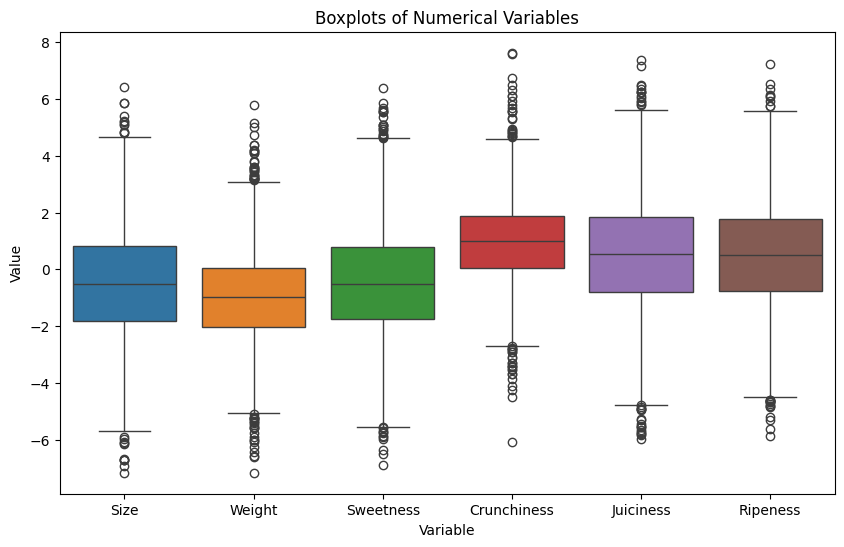

In [9]:
# Boxplots!

plt.figure(figsize=(10, 6))
sns.boxplot(data=raw_data[num_cols])
plt.title('Boxplots of Numerical Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.show()

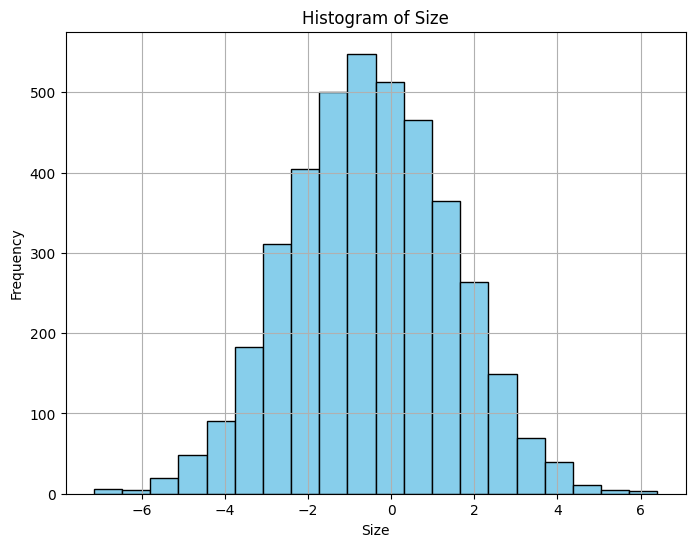

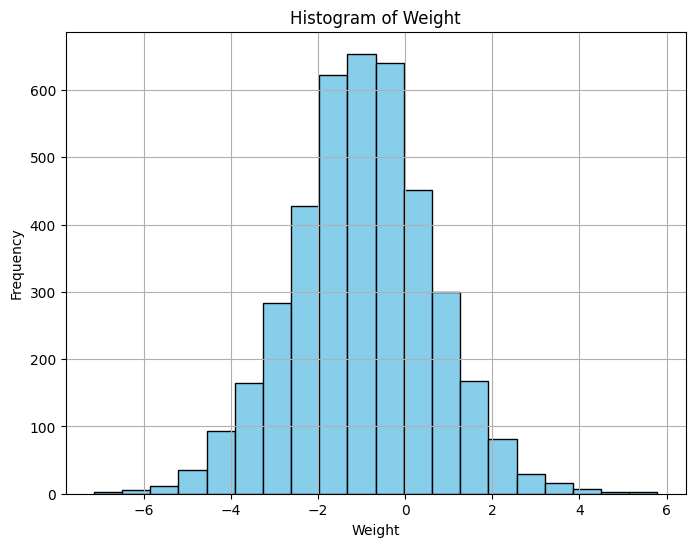

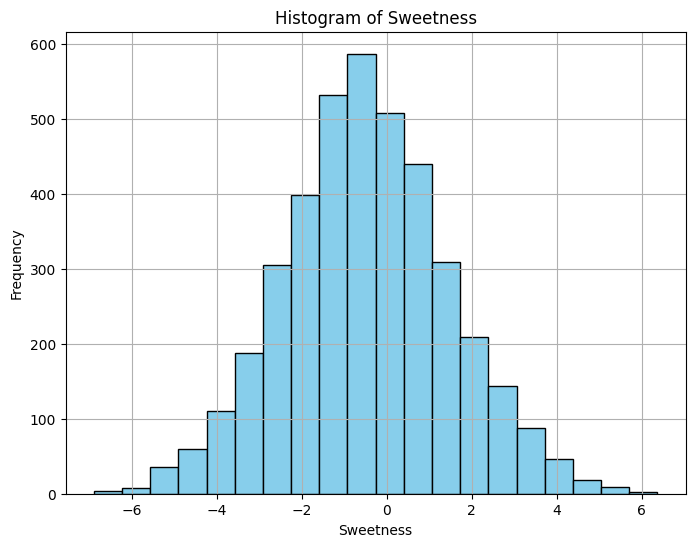

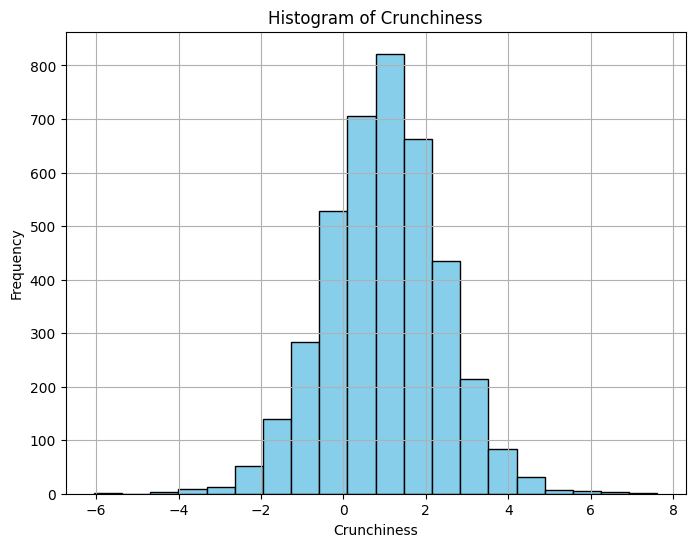

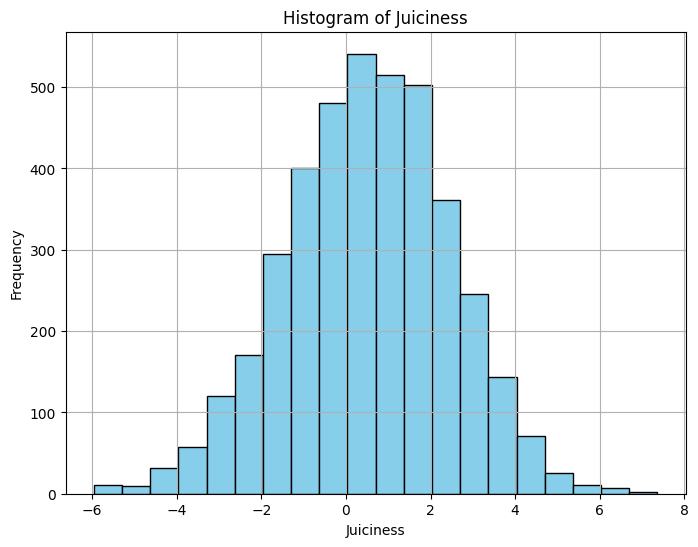

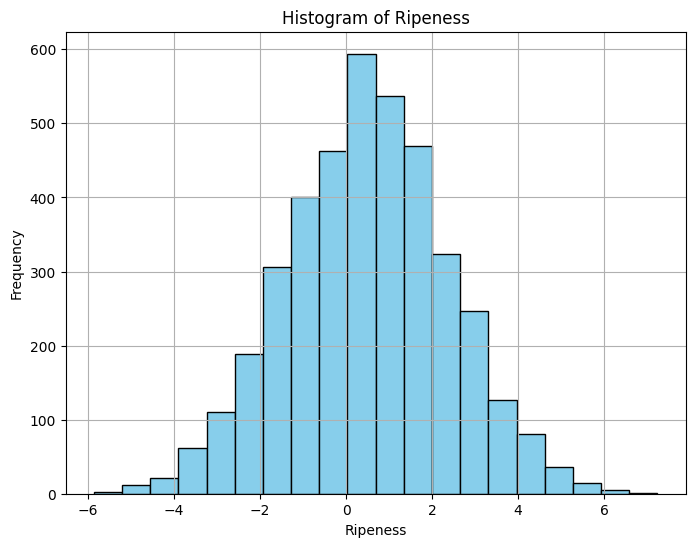

In [10]:
# Histograms!

for var in num_cols:
    plt.figure(figsize=(8, 6))
    plt.hist(raw_data[var], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

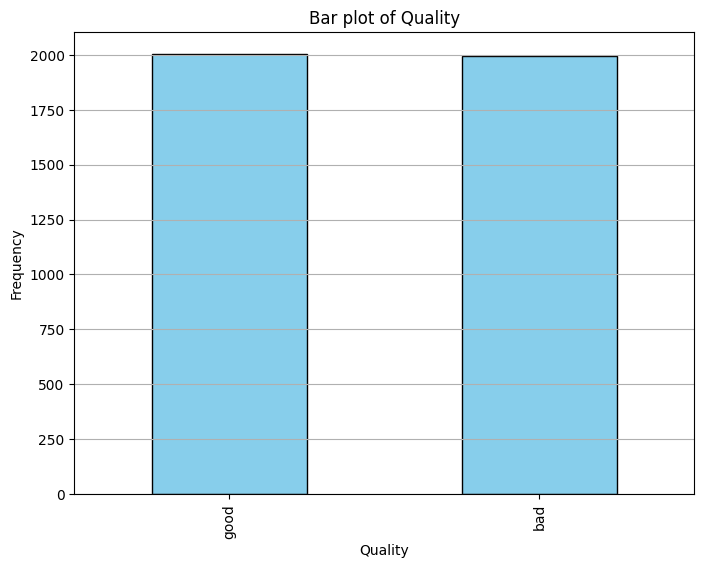

In [11]:
# Bar Plot!
category_counts = raw_data['Quality'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bar plot of Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

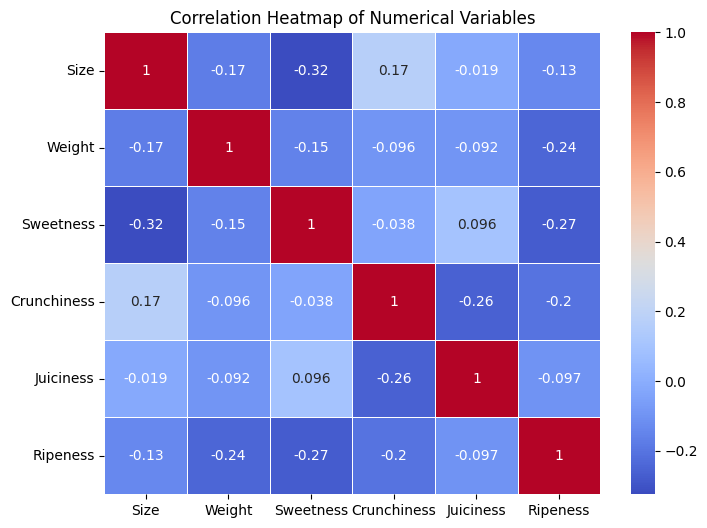

In [12]:
# Heatmap!
correlation_matrix = raw_data[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

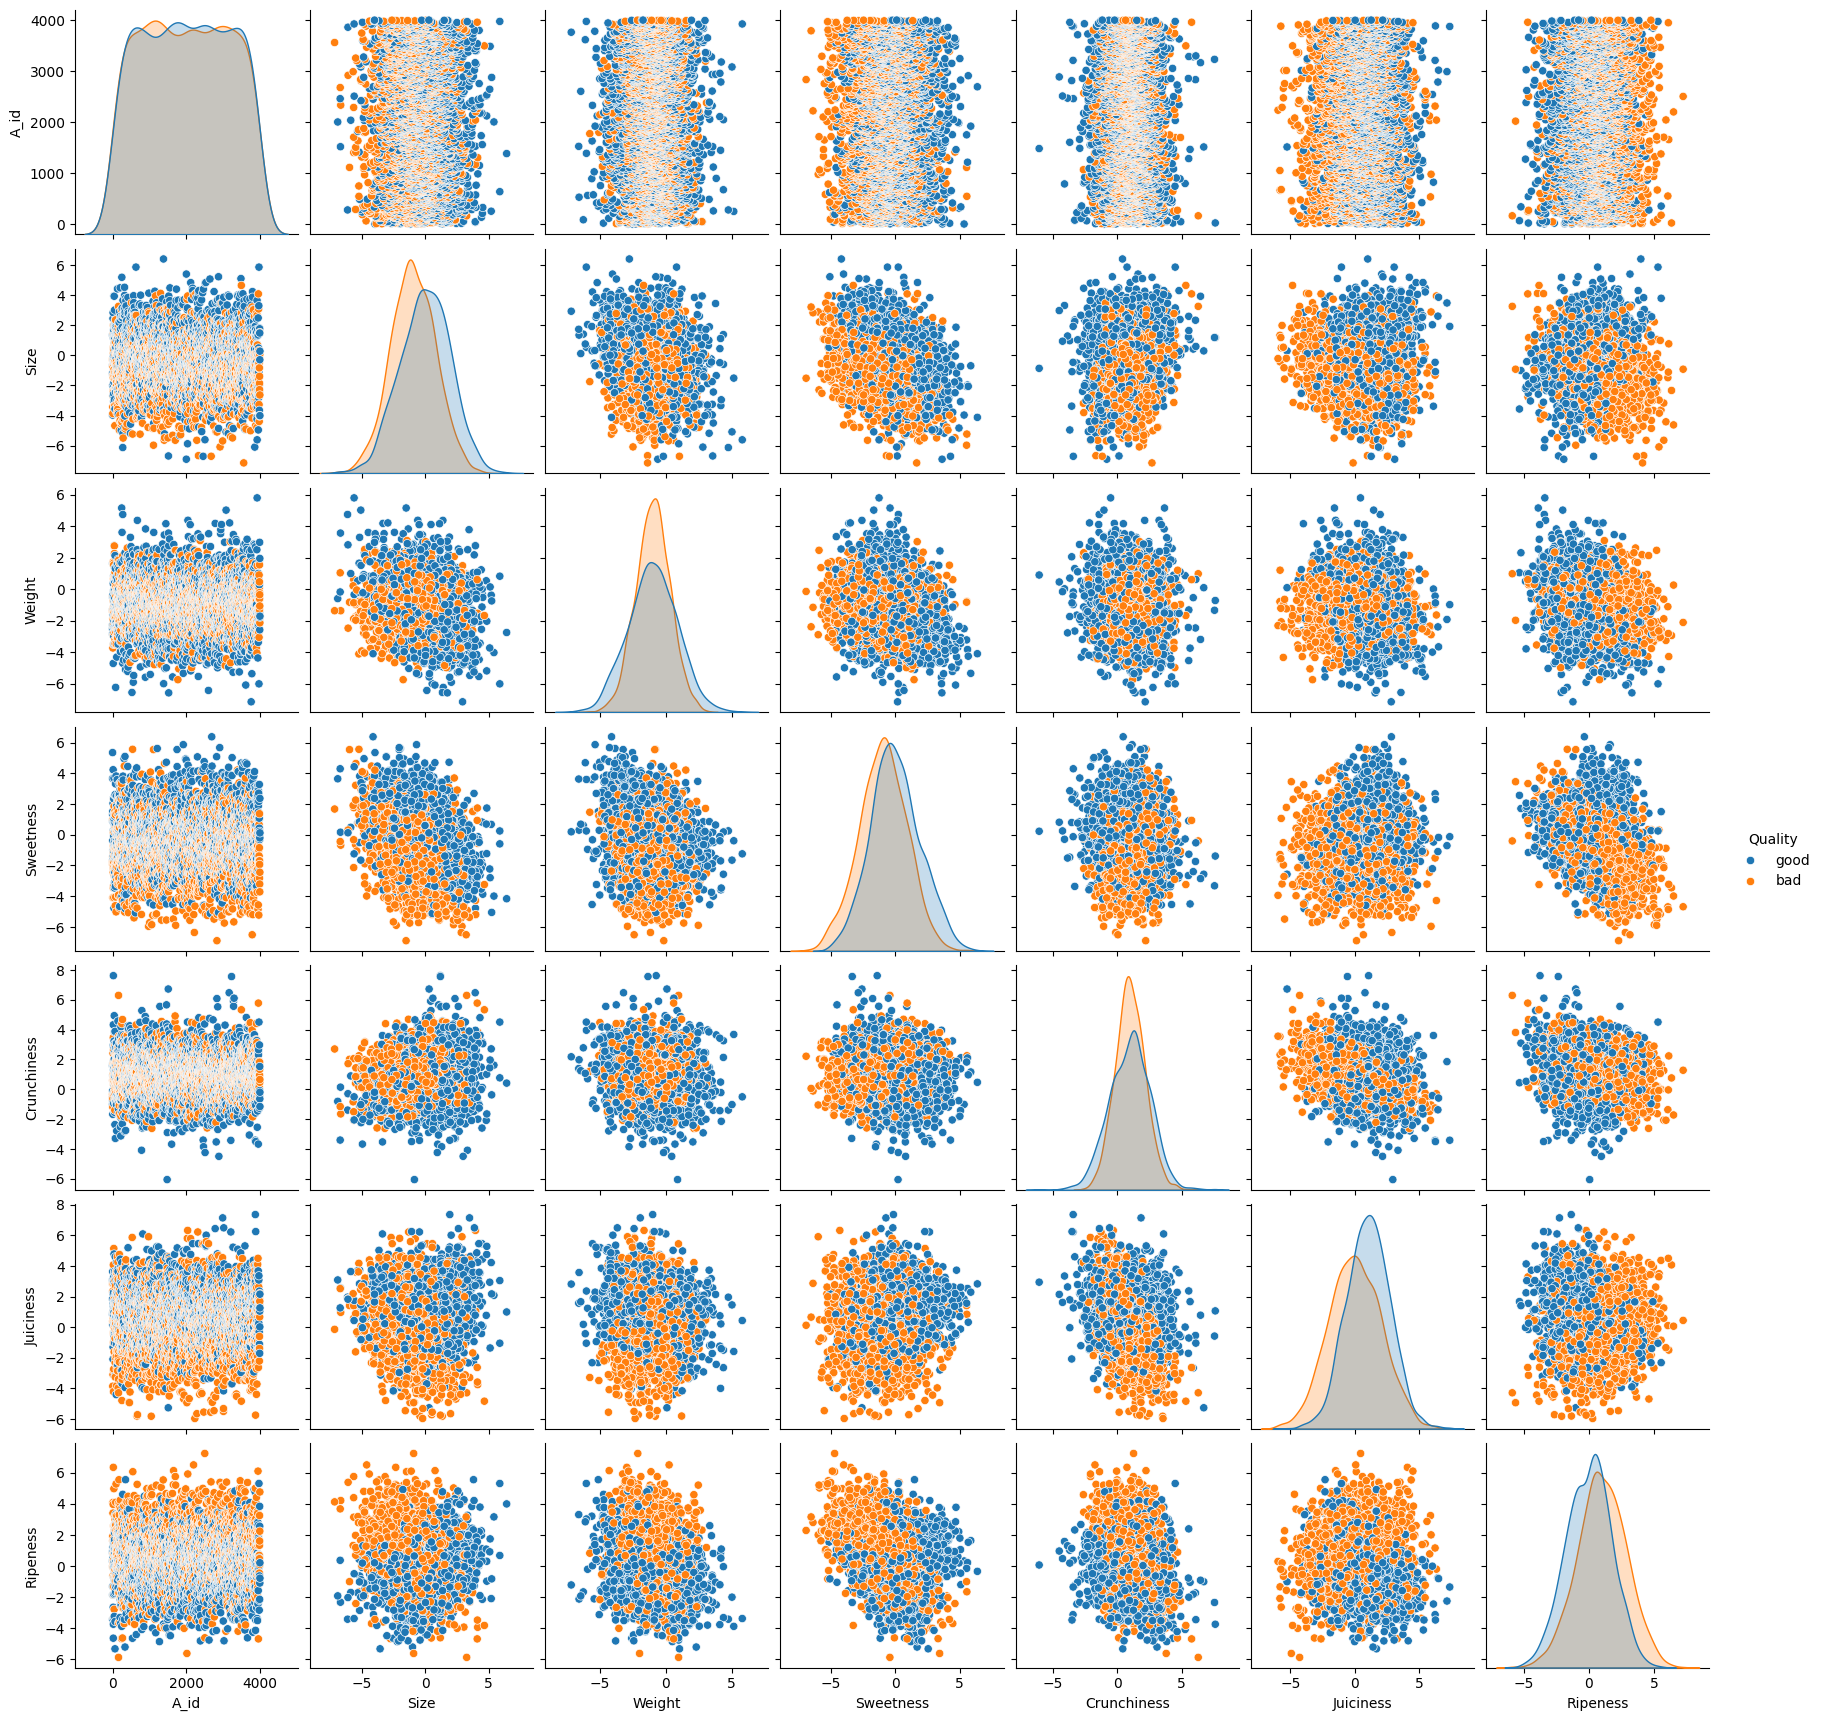

In [13]:
# THE pairplot!
sns.pairplot(raw_data, hue="Quality")
plt.show()

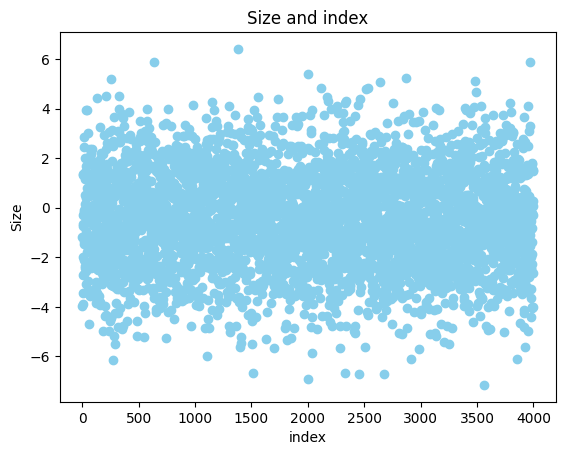

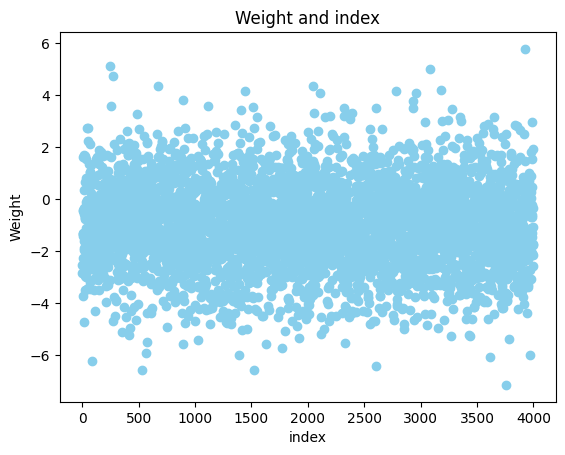

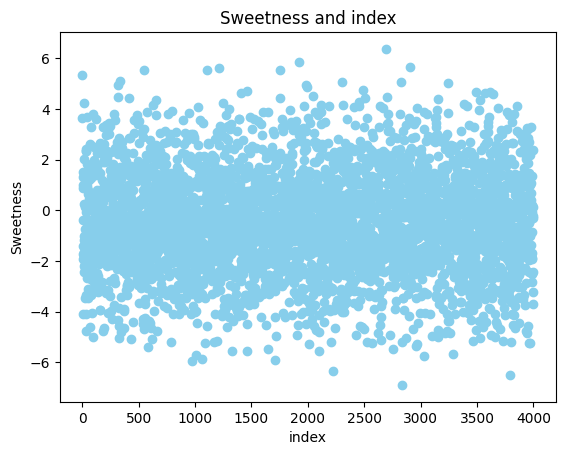

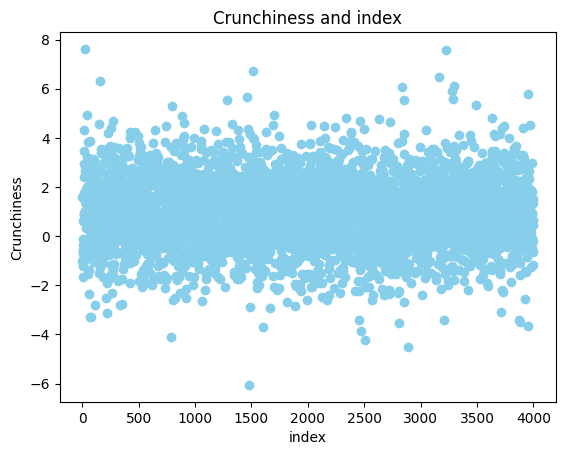

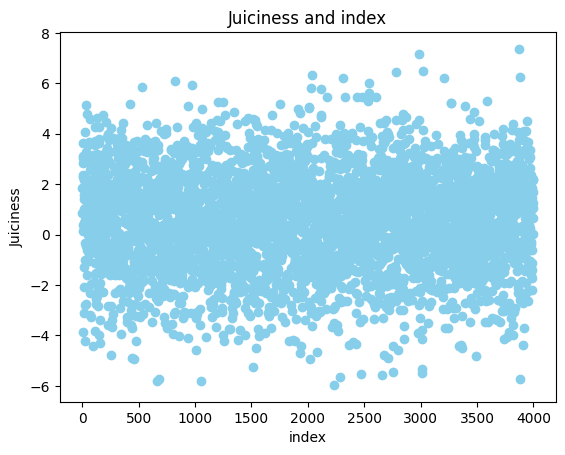

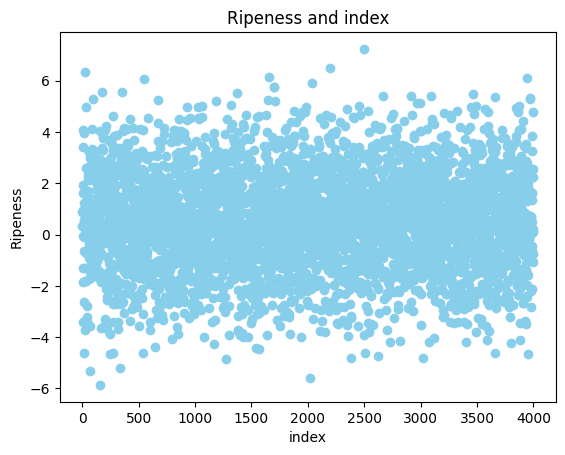

In [14]:
# Does the index somehow influence the variable? It doesn't!
def indexed_isit_sorted_test(df,features):

    for feature in features:
        plt.scatter(df.index, df[feature], c='skyblue')
        plt.xlabel("index")
        plt.ylabel(feature)
        plt.title(f"{feature} and index")
        plt.show()


indexed_isit_sorted_test(raw_data, num_cols)

___
# Cleaning
___

In [15]:
raw_data.drop(raw_data[raw_data.isnull().any(axis=1)].index, inplace=True)
raw_data['Acidity'] = pd.to_numeric(raw_data['Acidity'], errors='coerce')

In [16]:
data_cleaning = make_pipeline(
    DropColumnTransformer(columns=["A_id"]),
    FunctionTransformer(lambda X: X.drop_duplicates(), validate=False),
    CustomOutlierRemover(),
)

df_cleaned = data_cleaning.fit_transform(raw_data)
df_cleaned.head()

Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840 -0.491590   
1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530 -0.722809   
2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033  2.621636   
3 -0.657196 -2.271627   1.324874    -0.097875   3.637970 -3.413761  0.790723   
4  1.364217 -1.296612  -0.384658    -0.553006   3.030874 -1.303849  0.501984   

  Quality  
0    good  
1    good  
2     bad  
3    good  
4    good

___
# Preprocessing
___

In [17]:
preprocessing_pipeline = make_pipeline(
    CustomStandardScaler(columns=["Size", "Weight", "Sweetness", "Crunchiness", "Juiciness", "Ripeness", "Acidity"]),
)

___
# EDA After Cleaning & Preprocessing
___

In [18]:
print("\nSummary statistics for numerical variables:")
print(df_cleaned.describe())


Summary statistics for numerical variables:
              Size       Weight    Sweetness  Crunchiness    Juiciness  \
count  3903.000000  3903.000000  3903.000000  3903.000000  3903.000000   
mean     -0.511937    -0.990995    -0.471125     0.980617     0.519838   
std       1.885896     1.550028     1.910246     1.334950     1.881195   
min      -6.099551    -5.746384    -5.958315    -3.127340    -4.924983   
25%      -1.816040    -1.997478    -1.729070     0.077895    -0.791251   
50%      -0.524415    -0.984489    -0.504307     0.994335     0.528195   
75%       0.774258     0.021622     0.790041     1.879203     1.825988   
max       5.225383     3.772173     5.346330     4.937210     6.226448   

          Ripeness      Acidity  
count  3903.000000  3903.000000  
mean      0.515593     0.073821  
std       1.839423     2.080966  
min      -4.851519    -5.917900  
25%      -0.734297    -1.376742  
50%       0.521532     0.021319  
75%       1.771178     1.499513  
max       6.1025

In [19]:
print("\nSummary statistics for categorical variables:")
for column in df_cleaned.select_dtypes(include=['object']).columns:
    print("\n", column, ":")
    print(df_cleaned[column].value_counts())


Summary statistics for categorical variables:

 Quality :
Quality
bad     1964
good    1939
Name: count, dtype: int64


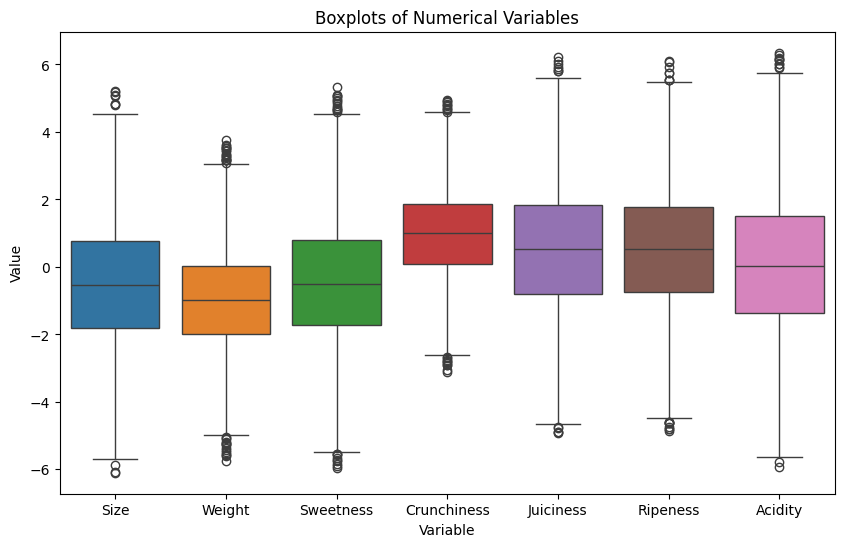

In [20]:
# Boxplots

num_cols_cleaned = ['Size','Weight','Sweetness','Crunchiness','Juiciness','Ripeness','Acidity']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned[num_cols_cleaned])
plt.title('Boxplots of Numerical Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.show()

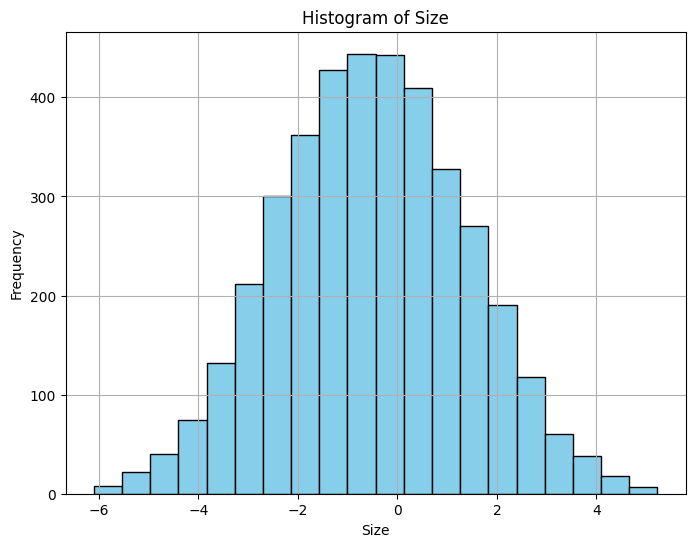

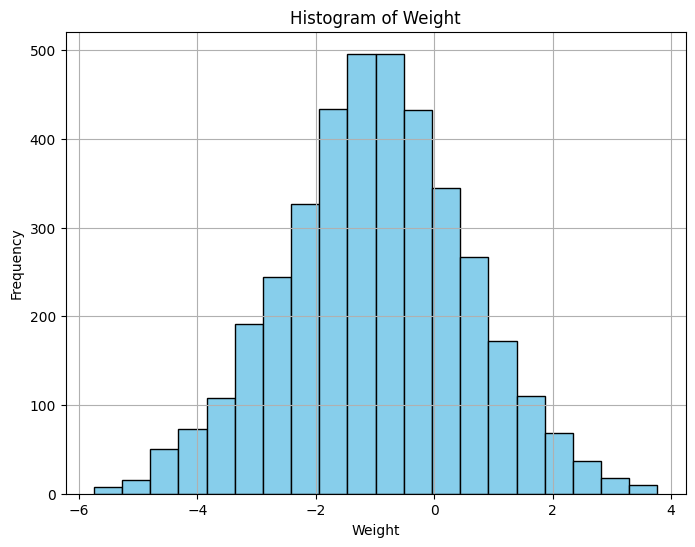

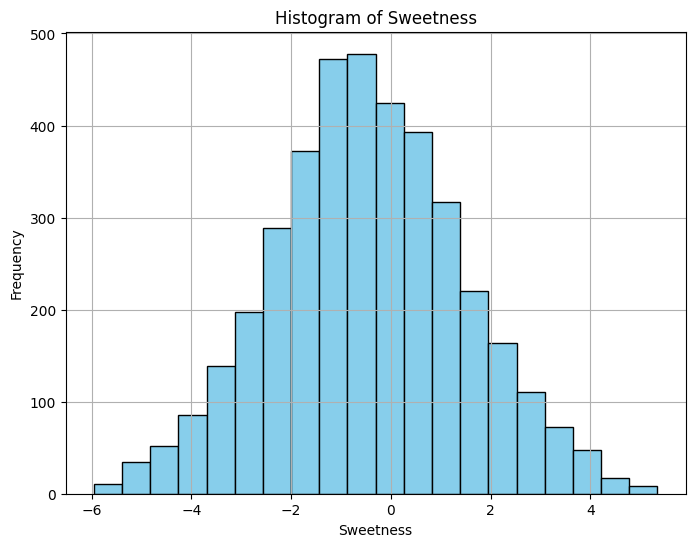

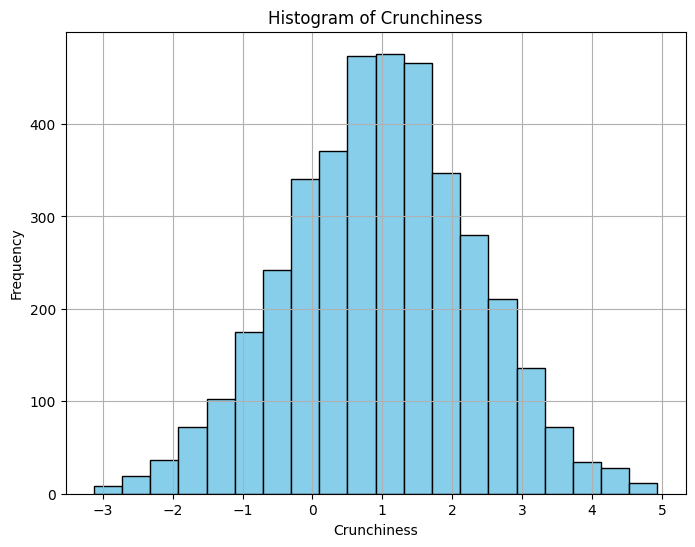

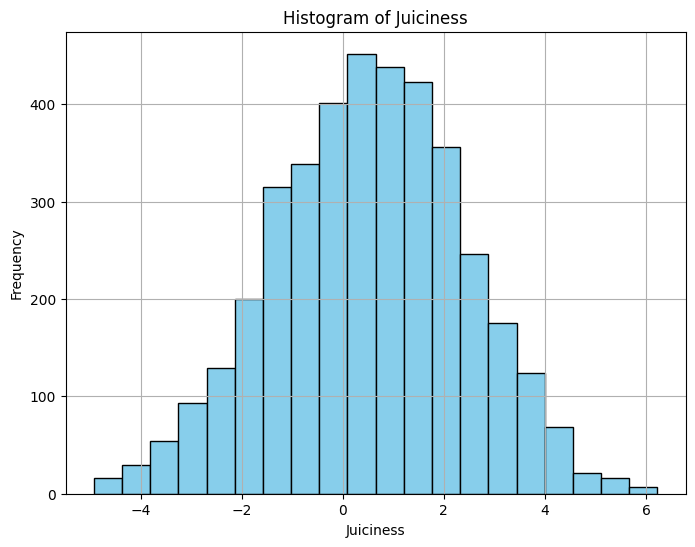

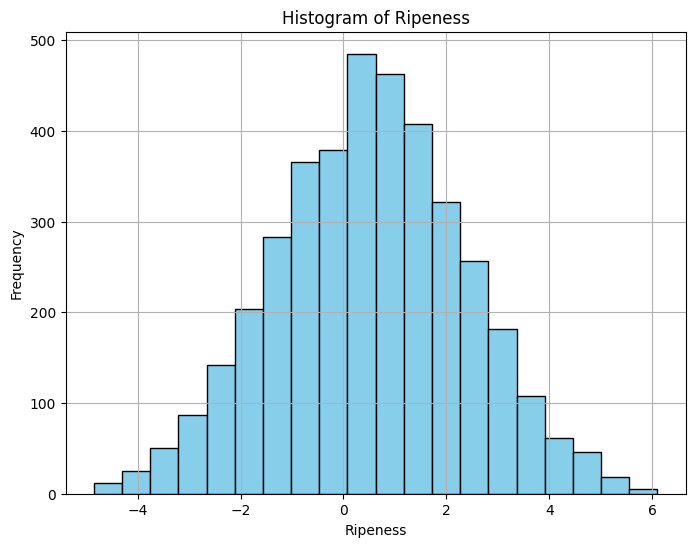

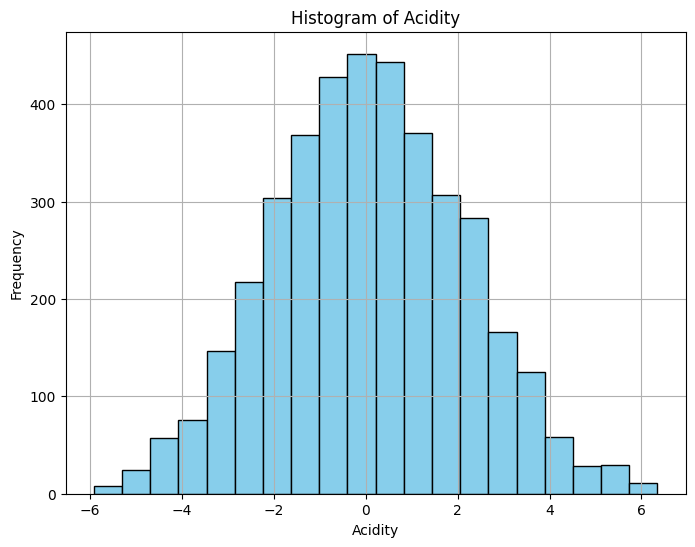

In [21]:
# Histograms

for var in num_cols_cleaned:
    plt.figure(figsize=(8, 6))
    plt.hist(df_cleaned[var], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

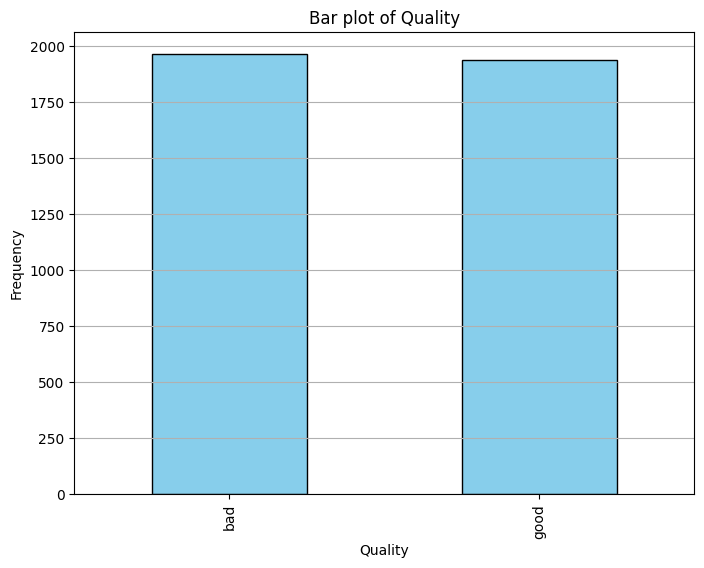

In [22]:
# Bar Plot
category_counts = df_cleaned['Quality'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bar plot of Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

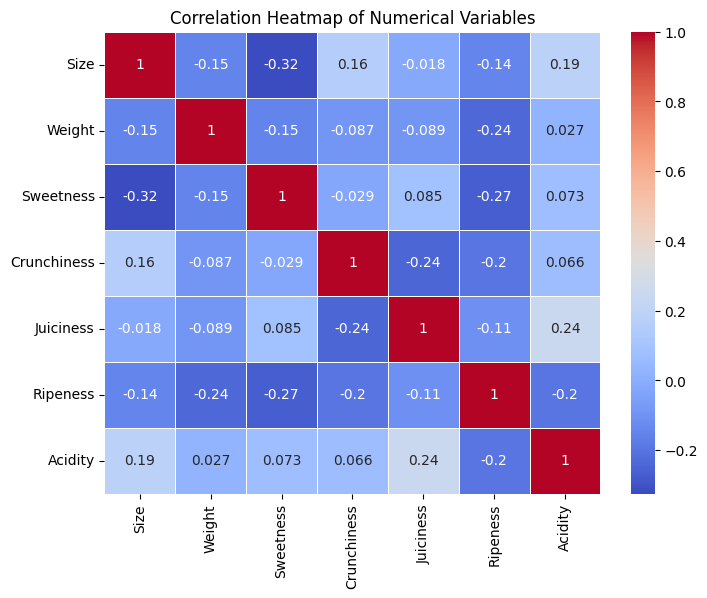

In [23]:
# Heatmap
correlation_matrix = df_cleaned[num_cols_cleaned].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

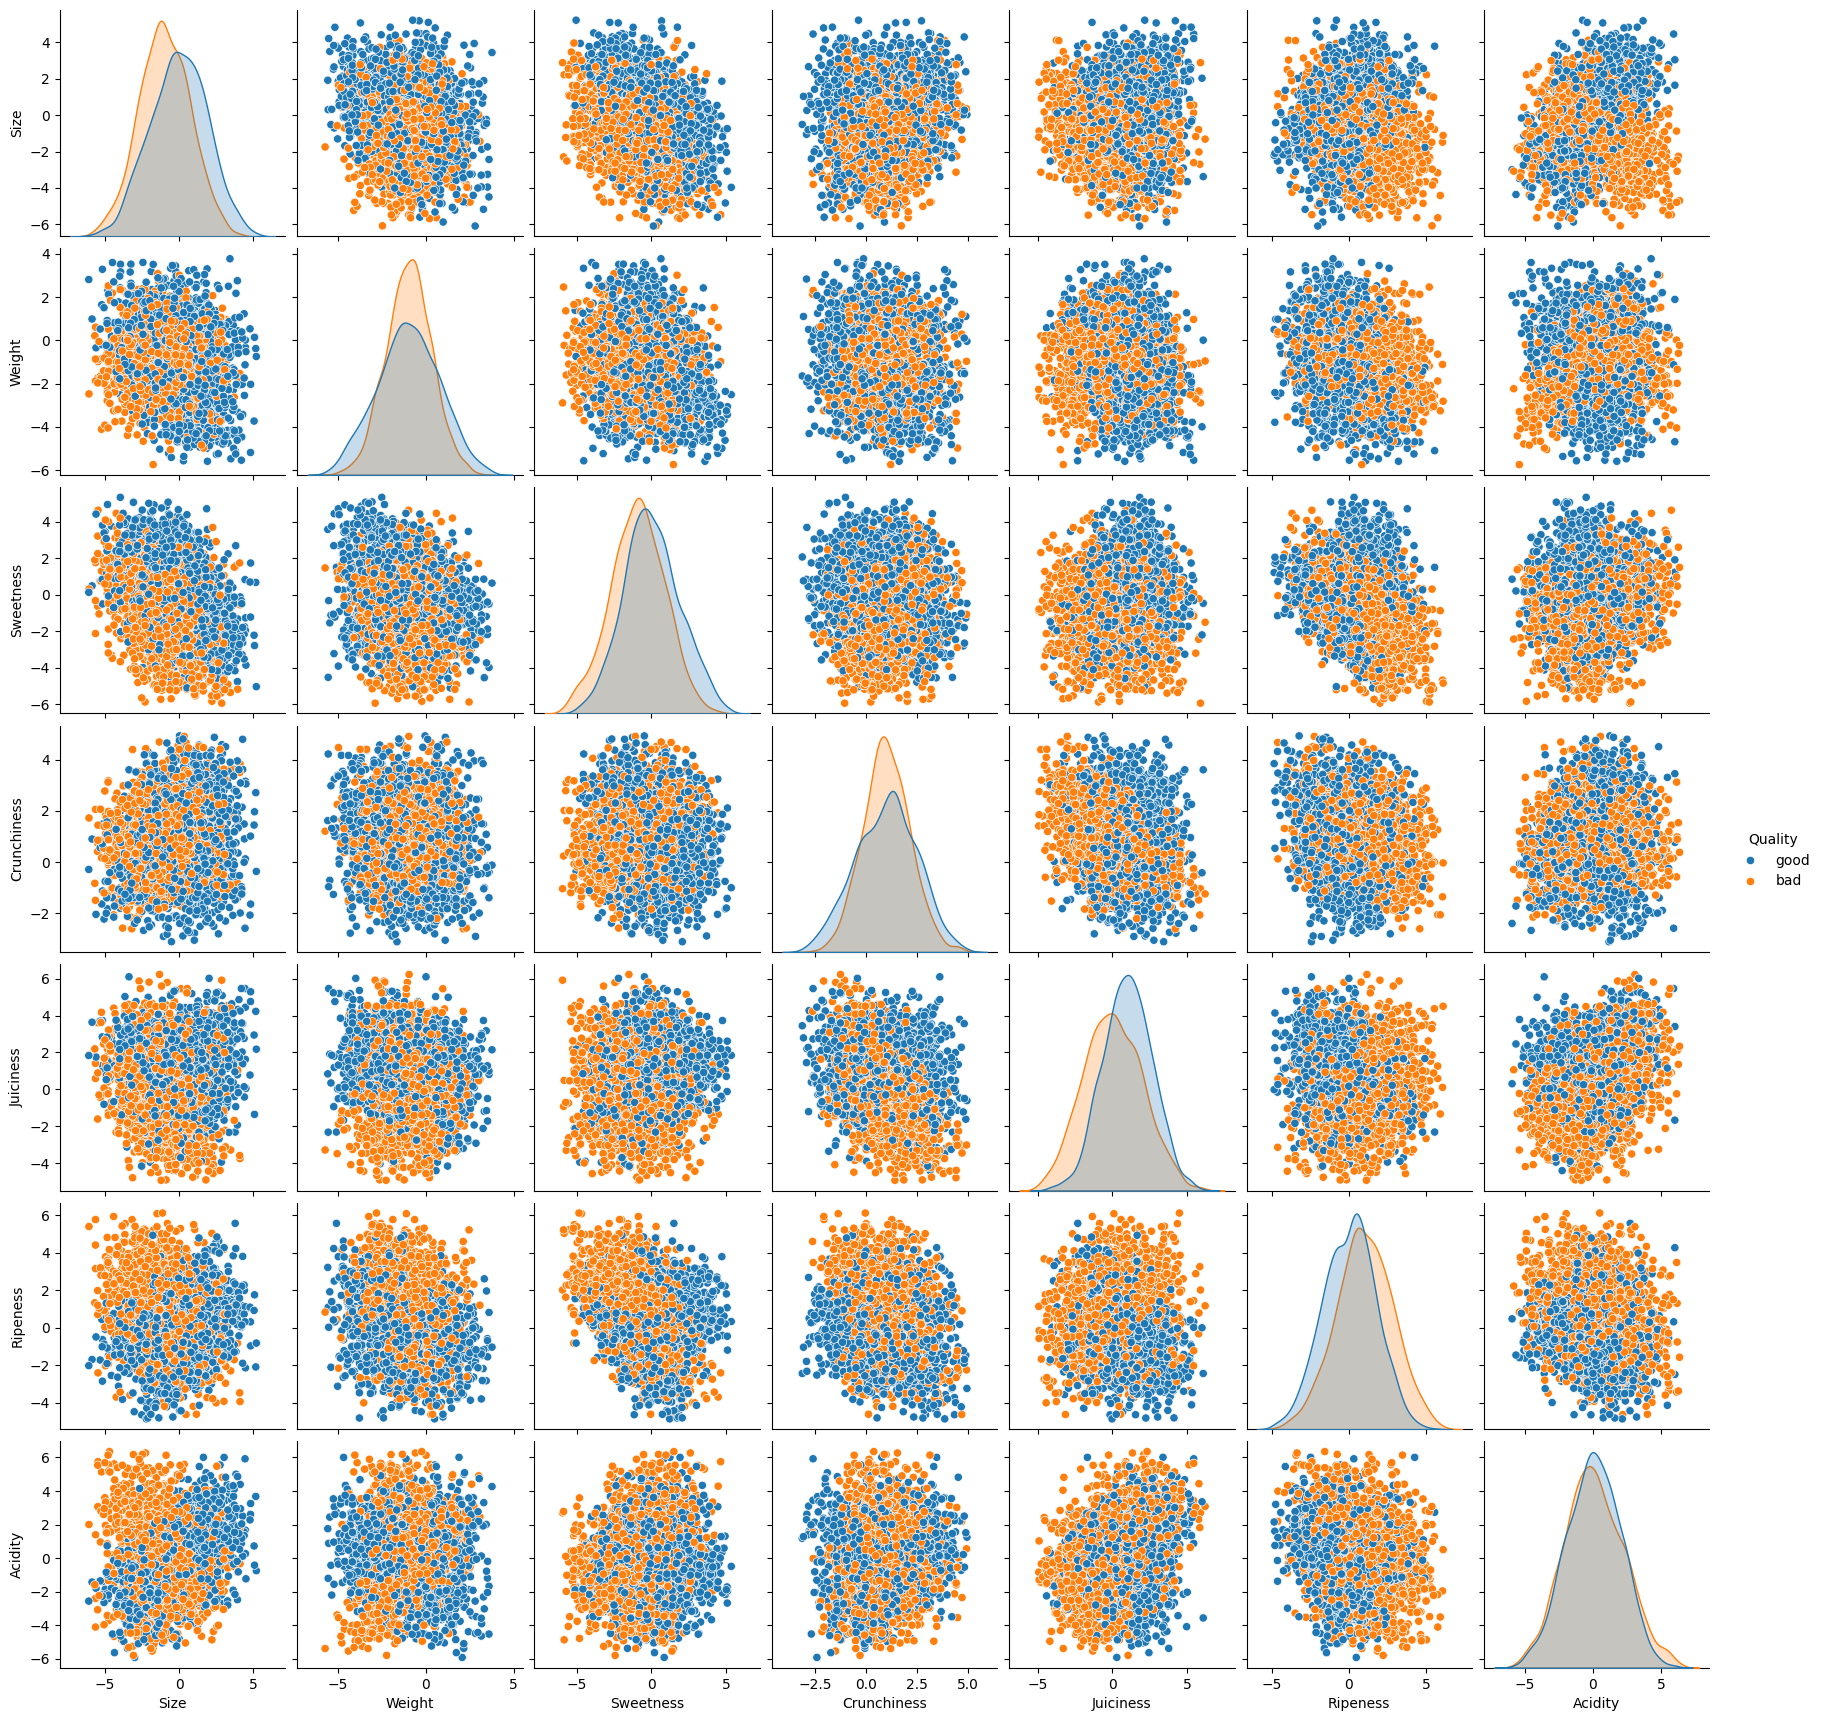

In [24]:
#Pairplot

sns.pairplot(df_cleaned, hue="Quality")
plt.show()

In [25]:
# ANOVA

anova_results = {}
for feature in num_cols_cleaned:
    good_quality = df_cleaned[df_cleaned['Quality'] == 'good'][feature]
    bad_quality = df_cleaned[df_cleaned['Quality'] == 'bad'][feature]
    anova_result = f_oneway(good_quality, bad_quality)
    anova_results[feature] = {
        'F-value': anova_result.statistic,
        'p-value': anova_result.pvalue
    }

for feature, result in anova_results.items():
    print(f"ANOVA results for {feature}:")
    print("F-value:", result['F-value'])
    print("p-value:", result['p-value'])
    print()


ANOVA results for Size:
F-value: 261.5376203331351
p-value: 5.447151686077249e-57

ANOVA results for Weight:
F-value: 0.021785907685541044
p-value: 0.8826656881877449

ANOVA results for Sweetness:
F-value: 262.1109194453654
p-value: 4.1597484163781495e-57

ANOVA results for Crunchiness:
F-value: 0.254208527560493
p-value: 0.6141556641613419

ANOVA results for Juiciness:
F-value: 271.57766125038887
p-value: 4.873585192751833e-59

ANOVA results for Ripeness:
F-value: 291.59923847815554
p-value: 4.1553864418980574e-63

ANOVA results for Acidity:
F-value: 0.6702460984579466
p-value: 0.4130158266532501



- For Size, Sweetness, Juiciness, and Ripeness, the F-values are high, and the p-values are extremely low (close to 0). This suggests that there are significant differences between the groups in terms of these attributes.

- For Weight, Crunchiness, and Acidity, the F-values are low, and the p-values are relatively high (close to 1 or above 0.05). This indicates that there are no significant differences between the groups for these attributes.

We can conclude that Size, Sweetness, Juiciness, and Ripeness seem to be important attributes, which significantly affect the dependent variable, while Weight, Crunchiness, and Acidity do not appear to have a significant impact.

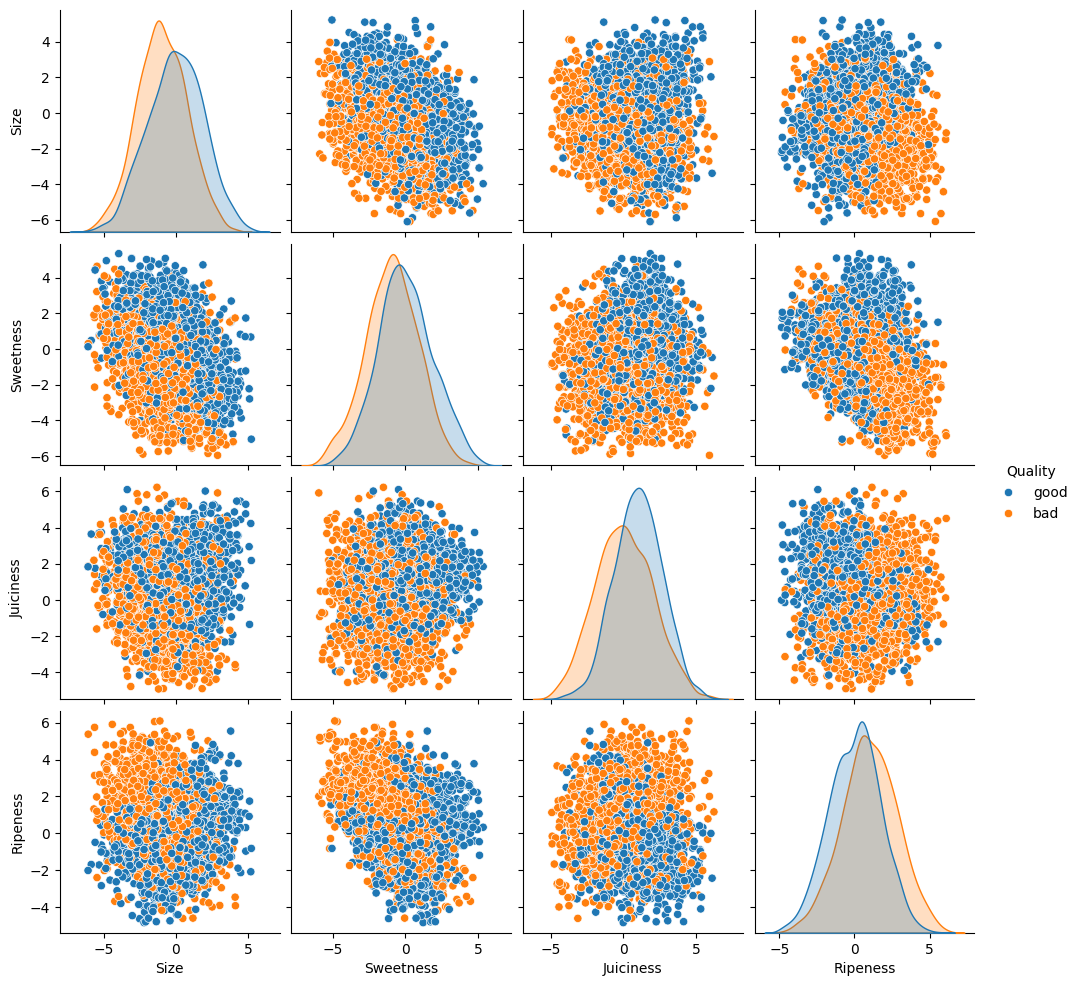

In [26]:
# Pairplot for the significant features

significant_features = ['Size', 'Sweetness', 'Juiciness', 'Ripeness', 'Quality']

sns.pairplot(df_cleaned[significant_features], hue = 'Quality')
plt.show()

___
# Classifiers
___

### Naive Bayes and MLP 

In [47]:
# Extract features
#initial_X = df_cleaned.iloc[:, :-1]
initial_X = df_cleaned[['Size', 'Weight', 'Sweetness', 'Crunchiness',
                       'Juiciness', 'Ripeness', 'Acidity']]

# Extract target
#initial_y = df_cleaned.iloc[:, -1]
initial_y = df_cleaned['Quality']

# Reserve 10% of the dataset as a validation set
# This is for the prediction purposes at the end (Confusion matrices)
X, X_validation, y, y_validation = train_test_split(initial_X, initial_y, 
                                                    test_size=0.1, random_state=42)

In [28]:
# Tune and Test NB
nb = GaussianNB()

nb_classifier = CustomClassifier(preprocessing_pipeline, nb, k_count=10)
nb_classifier.fit(X, y)

# Print Classification Report
classification_report_print(nb_classifier)


Overall Accuracy of NB: 0.75
Overall F1 Score of NB: 0.75
                     Classification Report of NB                      
                  bad        good  accuracy   macro avg  weighted avg
precision    0.752669    0.746258  0.748862    0.749464      0.749497
recall       0.746042    0.751770  0.748862    0.748906      0.748862
f1-score     0.748890    0.748579  0.748862    0.748734      0.748729
support    176.400000  174.800000  0.748862  351.200000    351.200000 



In [29]:
# Test MLP 
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 32, 64),
    activation="relu",
    solver="adam",
    max_iter=1000,
    random_state=42,
    )

mlp_classifier = CustomClassifier(preprocessing_pipeline, mlp, k_count=10)
mlp_classifier.fit(X, y)

# Print Classification Report
classification_report_print(mlp_classifier)

Overall Accuracy of MLP: 0.93
Overall F1 Score of MLP: 0.93
                    Classification Report of MLP:                     
                  bad        good  accuracy   macro avg  weighted avg
precision    0.933478    0.933879  0.933374    0.933679      0.933668
recall       0.934226    0.932493  0.933374    0.933359      0.933374
f1-score     0.933696    0.933022  0.933374    0.933359      0.933361
support    176.400000  174.800000  0.933374  351.200000    351.200000


### Random Forest and Support Vector Machine

In [30]:
rf = RandomForestClassifier(random_state=42)

params_grid_rf = {
    'n_estimators': [245, 250, 255],
    'min_samples_split': [3],
    'min_samples_leaf': [1, 2],
}

rf = GridSearchCV(estimator=rf, 
                 param_grid=params_grid_rf, 
                 cv=2,   
                 verbose=1, 
                 scoring='accuracy',
                 n_jobs=-1)

rf_classifier = CustomClassifier(preprocessing_pipeline, rf, k_count=5)
rf_classifier.fit(X, y)

print("Best Parameters:", rf.best_params_)
print(f"Average Accuracy of RF: {rf_classifier.accuracy:.3f}")
print(f"Average F1 Score of RF: {rf_classifier.f1:.3f}")

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 245}
Average Accuracy of RF: 0.890
Average F1 Score of RF: 0.890


In [31]:
rf_best_params = rf.best_params_
rf = RandomForestClassifier(**rf_best_params, random_state=42)

rf_classifier = CustomClassifier(preprocessing_pipeline, rf, k_count=10)
rf_classifier.fit(X, y)

classification_report_print(rf_classifier)

Average Accuracy of RF: 0.887
Average F1 Score of RF: 0.887
                     Classification Report of RF:                     
                  bad        good  accuracy   macro avg  weighted avg
precision    0.900008    0.875034  0.886676    0.887521      0.887572
recall       0.871870    0.901599  0.886676    0.886735      0.886676
f1-score     0.885403    0.887844  0.886676    0.886624      0.886620
support    176.400000  174.800000  0.886676  351.200000    351.200000


In [32]:
svm = SVC(random_state=42)

params_grid_svm = {
    'C': [0.1, 0.5, 1, 2, 10],  
    'gamma': ['scale', 'auto', 1, 0.1, 0.01],
    'kernel': ['rbf'],
    'degree': [0, 1, 2, 3, 4],
    'coef0': [0.0, 0.1, 0.5]
}

svm = GridSearchCV(estimator=svm, 
                 param_grid=params_grid_svm, 
                 cv=2,   
                 verbose=1, 
                 scoring='accuracy',
                 n_jobs=-1)

svm_classifier = CustomClassifier(preprocessing_pipeline, svm, k_count=5)
svm_classifier.fit(X, y)

print("Best Parameters:", svm.best_params_)
print(f"Average Accuracy of SVM: {svm_classifier.accuracy:.3f}")
print(f"Average F1 Score of SVM: {svm_classifier.f1:.3f}")

Fitting 2 folds for each of 375 candidates, totalling 750 fits
Fitting 2 folds for each of 375 candidates, totalling 750 fits
Fitting 2 folds for each of 375 candidates, totalling 750 fits
Fitting 2 folds for each of 375 candidates, totalling 750 fits
Fitting 2 folds for each of 375 candidates, totalling 750 fits
Best Parameters: {'C': 1, 'coef0': 0.0, 'degree': 0, 'gamma': 1, 'kernel': 'rbf'}
Average Accuracy of SVM: 0.915
Average F1 Score of SVM: 0.915


In [33]:
svm_best_params = svm.best_params_
svm = SVC(**svm_best_params, random_state=42)

svm_classifier = CustomClassifier(preprocessing_pipeline, svm, k_count=10)
svm_classifier.fit(X, y)

classification_report_print(svm_classifier)

Average Accuracy of SVM: 0.914
Average F1 Score of SVM: 0.914
                    Classification Report of SVM:                     
                  bad        good  accuracy   macro avg  weighted avg
precision    0.924091    0.905949  0.914009    0.915020      0.915074
recall       0.904224    0.923915  0.914009    0.914070      0.914009
f1-score     0.913550    0.914374  0.914009    0.913962      0.913959
support    176.400000  174.800000  0.914009  351.200000    351.200000


### Logistic Regression

In [34]:
log_reg = LogisticRegression(random_state=42)

log_reg_clf = CustomClassifier(preprocessing_pipeline, log_reg, k_count=10)
log_reg_clf.fit(X, y)



classification_report_print(log_reg_clf)

Average Accuracy of Logistic Regression: 0.75
Average F1 Score of Logistic Regression: 0.75
                  bad        good  accuracy   macro avg  weighted avg
precision    0.758302    0.740352  0.748571    0.749327      0.749360
recall       0.734072    0.763163  0.748571    0.748617      0.748571
f1-score     0.745580    0.751227  0.748571    0.748403      0.748396
support    176.400000  174.800000  0.748571  351.200000    351.200000


### Xgboost, ada, kNN

In [35]:
# Encode the target 
le = LabelEncoder()
encoded_y = pd.DataFrame(le.fit_transform(y))

xgboost = xgb.XGBClassifier(tree_method="hist")

params_grid_xgb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0]
}

xgboost = GridSearchCV(estimator=xgboost, 
                 param_grid=params_grid_xgb, 
                 cv=2,   
                 verbose=0, 
                 scoring='accuracy',
                 n_jobs=-1)

xgboost_classifier = CustomClassifier(preprocessing_pipeline, xgboost, k_count=20)
xgboost_classifier.fit(X, encoded_y)

print("Best Parameters for xgboost:", xgboost.best_params_)
print(f"Average Accuracy of xgboost: {xgboost_classifier.accuracy:.3f}")
print(f"Average F1 Score of xgboost: {xgboost_classifier.f1:.3f}")


Best Parameters for xgboost: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.7}
Average Accuracy of xgboost: 0.895
Average F1 Score of xgboost: 0.895


In [36]:
param_grid_ada = {
    'n_estimators': [500],
    'learning_rate':  [0.1],
    'algorithm': ['SAMME']
}
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=5,
                              random_state=1)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

ada_grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    cv=5,
    verbose=1,
    scoring='accuracy',
    n_jobs=-1
)

ada_classifier = CustomClassifier(preprocessing_pipeline, ada_grid_search, k_count=10)

ada_classifier.fit(X, y)

print("Best Parameters for AdaBoost:", ada_grid_search.best_params_)
print(f"Average Accuracy of AdaBoost: {ada_classifier.accuracy:.3f}")
print(f"Average F1 Score of AdaBoost: {ada_classifier.f1:.3f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 500}
Average Accuracy of AdaBoost: 0.860
Average F1 Score of AdaBoost: 0.860


In [37]:
kNN = KNeighborsClassifier()
k_range = list(range(1, 31))
kNN = GridSearchCV(estimator=kNN, 
                 param_grid= dict(n_neighbors=k_range), 
                 cv=2,   
                 verbose=1, 
                 scoring='accuracy',
                 n_jobs=-1)

kNN_classifier = CustomClassifier(preprocessing_pipeline, kNN, k_count=10)
kNN_classifier.fit(X, y)

print("Best Parameters for knn:", kNN.best_params_)
print(f"Average Accuracy of knn: {kNN_classifier.accuracy:.3f}")
print(f"Average F1 Score of knn: {kNN_classifier.f1:.3f}")

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Best Parameters for knn: {'n_neighbors': 10}
Average Accuracy of knn: 0.894
Average F1 Score of knn: 0.894


## Comparison and Visualization

In [39]:
# Add classifiers to the list
classifiers = {'Naive Bayes': nb_classifier, 'MLPerceptron': mlp_classifier, 
               'Random Forest': rf_classifier, 'Support Vector Machine': svm_classifier, 
               'LogisticRegression': log_reg_clf, 'XGBoost': xgboost_classifier, 
               'AdaBoost': ada_classifier, 'KNN': kNN_classifier}

scores = [ 
   {
      "classifiers" : classifier_name,
      "accuracy" : f'{classifier.accuracy:.2f}',
      "f1_score" : f'{classifier.f1:.2f}',
   } 
   for classifier_name, classifier 
   in classifiers.items()
]

scores_df = pd.DataFrame(scores)
scores_df

classifiers accuracy f1_score
0             Naive Bayes     0.75     0.75
1            MLPerceptron     0.93     0.93
2           Random Forest     0.89     0.89
3  Support Vector Machine     0.91     0.91
4      LogisticRegression     0.75     0.75
5                 XGBoost     0.89     0.89
6                AdaBoost     0.86     0.86
7                     KNN     0.89     0.89

### Overall Performance Metrics


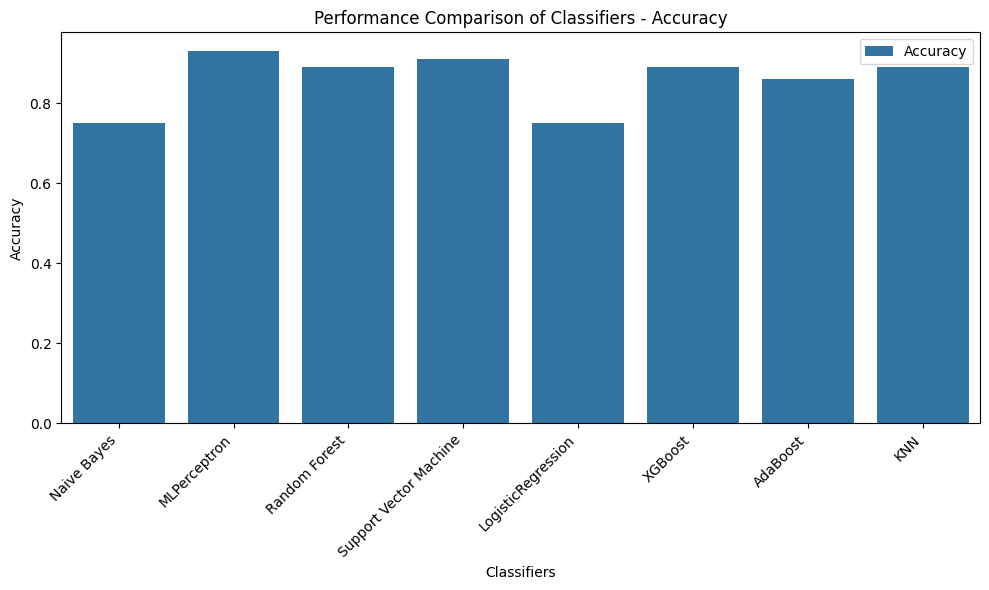

In [40]:
# Split scores and store them in separate lists
# classifiers_list = scores["classifiers"]
# accuracy_list = [float(acc) for acc in scores["accuracy"]]
# f1_score_list = [float(f1) for f1 in scores["f1_score"]]

# Accuracy Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=scores_df, x="classifiers", y="accuracy", label="Accuracy")

# Set title and labels
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Performance Comparison of Classifiers - Accuracy")

# Rotate classifier names
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
classifiers = {'Naive Bayes': nb_classifier, 'MLPerceptron': mlp_classifier, 
               'Random Forest': rf_classifier, 'Support Vector Machine': svm_classifier, 
               'LogisticRegression': log_reg_clf, 'XGBoost': xgboost_classifier, 
               'AdaBoost': ada_classifier, 'KNN': kNN_classifier}

### Confusion Matrices
We can use our reserved validation set here (`X_validation` and `y_validation`)

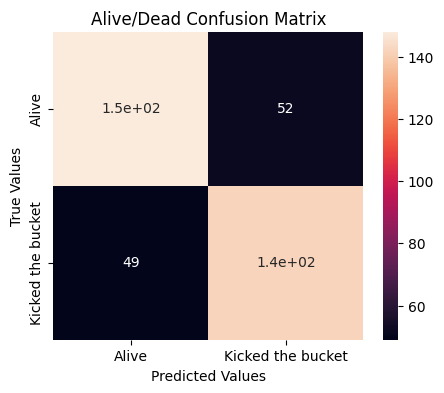

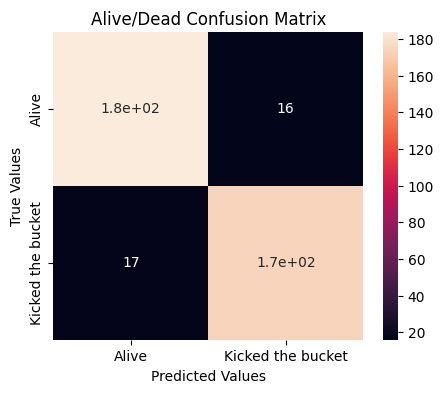

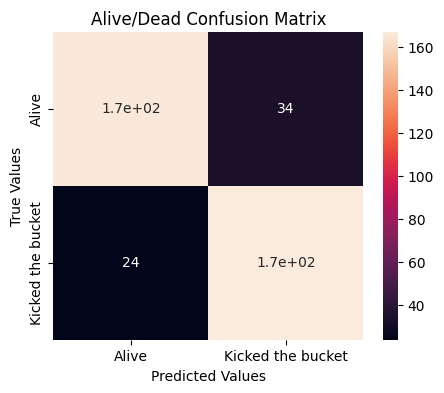

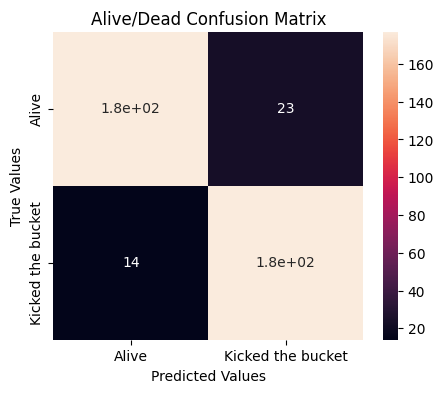

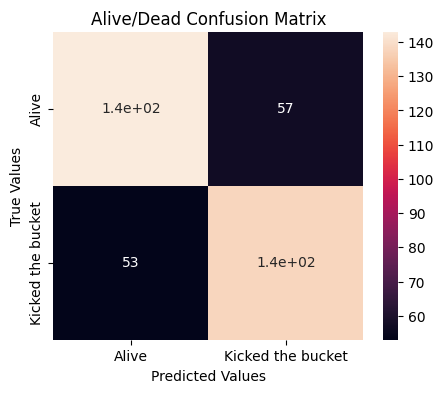

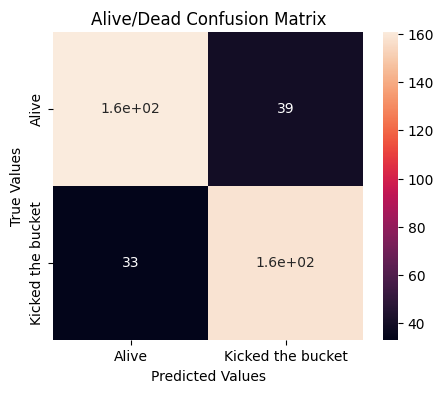

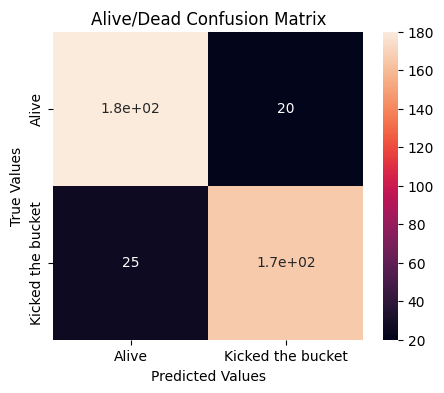

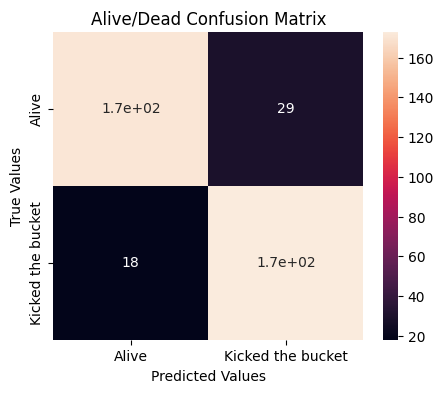

array([[171,  29],
       [ 18, 173]])

In [50]:
# Make Predictions
for name, classifier in classifiers.items():
    if name != 'XGBoost':
        y_pred = classifier.predict(X_validation)
        compute_and_plot_confusion_matrix(y_test=y_validation, y_pred=y_pred)


# Encode the target 
encoded_y_val = pd.DataFrame(le.fit_transform(y_validation))
y_pred = xgboost_classifier.predict(X_validation)
compute_and_plot_confusion_matrix(y_test=encoded_y_val, y_pred=y_pred)